## Research Ideas

- Add intercept and percetange of nodes in LCC for Coefficient Vs Jiggle Plots
- Question, is the model fitting well because we are far enough away from 4.52 (Percolation Constant) 
- Or, is the model fitting well because we have most nodes in the LCC i.e. because our numerical approximations are grouped into the a.s. connected case

## Hypothesis:
- I think that the model fits well when mean degree is high because we get far away from the numerical percolation constant.
- Test: at mean degree 7, we need more than 1000 nodes to not be almost surely connected, when we have less than 1000, vs more than 1000 it seems the fit does not change suggesting our hypothesis is right.
- I think the model works because we have established a robust well-meshed surface when the mean degree is high enough, not because we have eliminated every isolated node.


===== Simulation 1 =====
Graph Statistics:
  Radius: 0.016927
  Nodes: 10000
  Edges: 45581
  Average degree: 9.116
  Min degree: 1
  Max degree: 23
  Density: 0.000912
  Avg clustering coefficient: 0.5865
  Largest component size: 99.90%


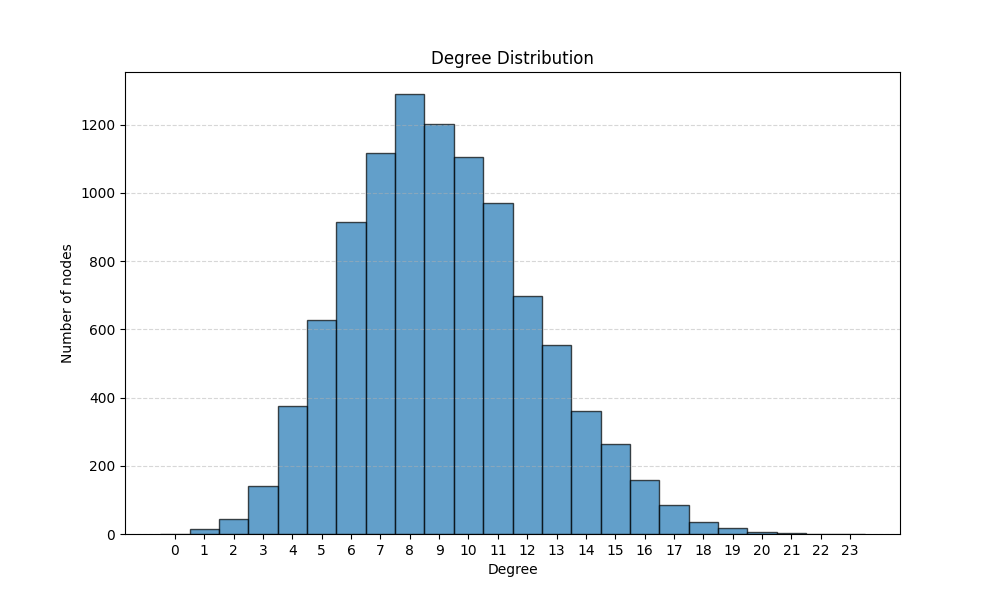

In [ ]:
%matplotlib widget

import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import sys, os, webbrowser
import warnings

# --- NEW IMPORTS FOR ML ---
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

sys.path.insert(0, "/Users/for/Desktop") 
from RGG_Library import RGGBuilder, RGGVisualizer

space_ = "torus"
use_angles = True
features_ = [0, "invdegfixed"][0]
perturb_bool = False
perturb_scale_ = 1
perturb_radius_multiplier_ = 1


def run_simulation(n=500, k=1.01, nsamples=1000, iteration=0):
    print(f"\n===== Simulation {iteration+1} =====")
    
    # --- RGG GENERATION ---
    builder = RGGBuilder(n=n, k=k, connectivity_regime="sc", space=space_, order=4, perturb = perturb_bool, 
                 perturb_scale = perturb_scale_, perturb_radius_multiplier = perturb_radius_multiplier_, seed=iteration) 
    
    G = builder.build()

    # --- Manually ensure Giant Component (GC) is used ---
    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        if components:
            Gsub = G.subgraph(max(components, key=len)).copy()
        else:
            print(f"Warning: Graph is empty in iteration {iteration}. Skipping.")
            return
    else:
        Gsub = G

    Gsub = nx.convert_node_labels_to_integers(Gsub, ordering="sorted")
    
    # Graph Stats
    builder.print_graph_stats(G, radius=builder.radius)
    builder.plot_degree_distribution(Gsub)

    # --- Sampling ---
    random.seed(iteration)
    np.random.seed(iteration)
    
    if use_angles:
        res, degs, dists, pairs, angles = RGGBuilder.sample_commute_times_even_distance_w_angles(
            Gsub, nsamples=nsamples, n_bins=20, seed=iteration, min_dist =  builder.radius, max_dist = 2
        )
    else:
        res, degs, dists, pairs = RGGBuilder.sample_commute_times_even_distance(
            Gsub, nsamples=nsamples, n_bins=20, seed=iteration, min_dist = builder.radius, max_dist = 2
        )

    if len(res) < 10:
        print("Not enough samples for Lasso regression.")
        return G, Gsub

    # ---------------------------
    # FEATURE ENGINEERING
    # ---------------------------
    safe_dists = dists.copy()
    safe_dists[safe_dists == 0] = 1e-9

    current_angles = angles if use_angles else np.zeros_like(dists)

    if features_ == "invdegfixed":
        
        feature_dict = {
            "Log(Dist)": np.log(safe_dists),      # The primary 2D diffusion
            "Dist^2": dists**2,                   # The uniform background
            "d^4 * cos(4theta)": dists**4 * np.cos(4*current_angles),
            "d^8 * cos(8theta)": dists**8 * np.cos(8*current_angles),
        }

    else:
        feature_dict = {
            "Dist^2": dists**2,
            "Log(Dist)": np.log(safe_dists),
            "d^4 * cos(4theta)": dists**4 * np.cos(4*current_angles),
            "d^8 * cos(8theta)": dists**8 * np.cos(8*current_angles),
            "InvDegSum": degs,
        }

    feature_names = list(feature_dict.keys())
    X = np.column_stack(list(feature_dict.values()))
    y = res

    # ---------------------------
    # LASSO REGRESSION (L1)
    # ---------------------------
    print(f"\n--- Running Lasso ---")
    
    # We train on Scaled Data to let Lasso work effectively
    model = make_pipeline(
        StandardScaler(), 
        Lasso(alpha=1e-6, random_state=0, max_iter=50000)
    )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") 
        model.fit(X, y)

    # ---------------------------
    # EXTRACT COEFFICIENTS & PREDICT MANUALLY
    # ---------------------------
    
    # 1. Get components from pipeline
    lasso = model.named_steps['lasso']
    scaler = model.named_steps['standardscaler']
    
    # 2. Get Scaled Coefficients (for Feature Importance)
    scaled_coefs = lasso.coef_
    scaled_intercept = lasso.intercept_
    
    # 3. Calculate Unscaled (Real) Coefficients (for Physical Formula)
    # Real_Beta = Scaled_Beta / Sigma
    # Real_Intercept = Scaled_Intercept - Sum(Real_Beta * Mean)
    sigmas = scaler.scale_
    means = scaler.mean_
    
    real_coefs = scaled_coefs / sigmas
    real_intercept = scaled_intercept - np.sum(real_coefs * means)

    # 4. Generate Predictions using REAL coefficients (Manual Calculation)
    # This verifies that the unscaled formula works
    y_pred_manual = (X @ real_coefs) + real_intercept
    
    # Calculate residuals and score based on this manual prediction
    residuals = y - y_pred_manual
    
    # Recalculate R2 manually to be sure
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    manual_r2 = 1 - (ss_res / ss_tot)

    print(f"\nAlpha (User-defined): {lasso.alpha:.6f}")
    print(f"Lasso R² (Calculated from Real Coefs): {manual_r2:.4f}")
    
    # --- PART 1: Scaled Coefficients (Feature Importance) ---
    print("\n[Scaled] Feature Importance (Relative Strength):")
    print("-" * 50)
    
    sorted_idx = np.argsort(np.abs(scaled_coefs))[::-1]
    
    found_any = False
    for i in sorted_idx:
        if abs(scaled_coefs[i]) > 1e-6: 
            print(f"{feature_names[i]:<20} : {scaled_coefs[i]:.6f}")
            found_any = True
    
    if not found_any:
        print("(Lasso shrank all coefficients to zero - try a smaller alpha)")
    print("-" * 50)

    # --- PART 2: Unscaled Coefficients (The Physical Equation) ---
    print("\n[Unscaled] Physical Formula (True Units):")
    print(f"Real Intercept       : {real_intercept:.6f}")
    print("-" * 50)
    
    for i in sorted_idx:
        if abs(scaled_coefs[i]) > 1e-6: 
            print(f"{feature_names[i]:<20} : {real_coefs[i]:.8f}")
    print("-" * 50)


    # ---------------------------
    # VISUALIZATION
    # ---------------------------
    fig = plt.figure(figsize=(12, 10))
    cmap = "viridis"

    # 1. Feature Importance (Top Left - 2D)
    ax1 = fig.add_subplot(2, 2, 1)
    # Plot scaled coefs to show importance
    ax1.barh(feature_names, scaled_coefs, color='teal')
    ax1.axvline(0, color='k', linewidth=0.8)
    ax1.set_title("Lasso Feature Importance (Scaled)")
    ax1.set_xlabel("Coefficient Magnitude")

    # 2. Fit: Predicted vs Observed (Top Right - 2D)
    ax2 = fig.add_subplot(2, 2, 2)
    # Uses y_pred_manual
    sc1 = ax2.scatter(y_pred_manual, y, c=degs, cmap=cmap, alpha=0.5, s=15)
    lims = [min(y.min(), y_pred_manual.min()), max(y.max(), y_pred_manual.max())]
    ax2.plot(lims, lims, 'r--', lw=1.5)
    ax2.set_title(f"Model Fit (R²={manual_r2:.3f})")
    ax2.set_xlabel("Predicted Resistance (Manual Unscaled)")
    ax2.set_ylabel("Observed Resistance")
    plt.colorbar(sc1, ax=ax2, label="1/du + 1/dv")

    # 3. Residuals vs Distance (Bottom Left - 2D)
    ax3 = fig.add_subplot(2, 2, 3)
    # Uses residuals from y_pred_manual
    sc2 = ax3.scatter(dists, residuals, c=degs, cmap=cmap, alpha=0.5, s=15)
    ax3.axhline(0, color='r', linestyle='--')
    ax3.set_title("Residuals vs Distance")
    ax3.set_xlabel("Toroidal Distance")
    ax3.set_ylabel("Residual (Obs - Pred)")
    plt.colorbar(sc2, ax=ax3, label="1/du + 1/dv")

    # 4. 3D PLOT
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    sc3 = ax4.scatter(dists, degs, y, c=degs, cmap=cmap, alpha=0.4, s=20, label='Observed')
    
    # Uses y_pred_manual
    ax4.scatter(dists, degs, y_pred_manual, c='k', alpha=0.2, s=5, label='Predicted (Formula)')

    ax4.set_title("3D Profile: Dist vs Deg vs Res")
    ax4.set_xlabel("Distance")
    ax4.set_ylabel("Inv Deg Sum")
    ax4.set_zlabel("Resistance")
    ax4.legend()
    ax4.view_init(elev=15, azim=315)
    plt.colorbar(sc3, ax=ax4, label="1/du + 1/dv")

    plt.tight_layout()
    plt.show()

    return G, Gsub

# ---------------------------
# RUN
# ---------------------------1

G, Gsub = run_simulation(n = 10000, k=9, nsamples=2000, iteration=0)

"""
viz = RGGVisualizer().from_networkx(Gsub)
out_file = os.path.abspath("out_rgg_lasso.html")
viz.show_html(out_file, largest_gc=True, metric="toroidal")
webbrowser.open(f"file://{out_file}")
"""

## Torus ML Test - 1000 nodes, mean degree 22

In [ ]:
%matplotlib widget
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import sys, os, webbrowser
import warnings

# --- ML IMPORTS ---
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# --- LIBRARY IMPORTS ---
sys.path.insert(0, "/Users/for/Desktop") 
from RGG_Library import RGGBuilder, RGGVisualizer

# --- CONFIGURATION ---
space_ = "torus"  # Switch to "triangular_torus" if needed
features_ = [0, "invdegfixed"][0] # 0 = Normal features, 1 = Triangle features

TOTAL_SEEDS = 100
TEST_SPLIT_INDEX = 70  # Seeds 0 to 69 are TRAIN, 70 to 99 are TEST

def get_feature_matrix(degs, dists):
    """
    Centralized feature engineering to ensure Training and Test sets 
    have identical columns.
    """
    # Avoid log(0)
    safe_dists = dists.copy()
    safe_dists[safe_dists == 0] = 1e-9

    feature_dict_normal = {
        "InvDegSum": degs,                                  
        "Sqrt(Dist)": np.sqrt(dists),                       
        "Dist": dists,                                      
        "Dist^2": dists**2,                                 
        "Dist^3": dists**3,                                 
        "Log(Dist)": np.log(safe_dists),                    
        "InvDeg * Dist": degs * dists,                      
        "InvDeg * Log(Dist)": degs * np.log(safe_dists),    
        "InvDeg * Sqrt(Dist)": degs * np.sqrt(dists)     
    }
    
    feature_dict_triangle = {
        "Sqrt(Dist)": np.sqrt(dists),                       
        "Dist": dists,                                      
        "Dist^2": dists**2,                                 
        "Dist^3": dists**3,                                 
        "Log(Dist)": np.log(safe_dists),                    
    }

    if features_ == "invdegfixed":
        feature_dict = feature_dict_triangle
    else:
        feature_dict = feature_dict_normal

    feature_names = list(feature_dict.keys())
    X = np.column_stack(list(feature_dict.values()))
    return X, feature_names

def generate_data(seed, n, k, nsamples):
    """
    Generates one graph and samples data for a single seed.
    """
    # sc for fixed mean degree
    builder = RGGBuilder(n=n, k=k, connectivity_regime="sc", space=space_, order=4, 
                         perturb=False, perturb_scale=0.5, perturb_radius_multiplier=1, seed=seed) 
    
    G = builder.build()

    # Ensure Giant Component
    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        if components:
            Gsub = G.subgraph(max(components, key=len)).copy()
        else:
            return None, None, None, None, None # Empty graph
    else:
        Gsub = G

    Gsub = nx.convert_node_labels_to_integers(Gsub, ordering="sorted")
    
    # Sampling
    random.seed(seed)
    np.random.seed(seed)
    
    res, degs, dists, pairs = RGGBuilder.sample_commute_times_even_distance(
        Gsub, nsamples=nsamples, n_bins=10, seed=seed, min_dist=builder.radius
    )
    
    if len(res) < 10:
        return None, None, None, None, Gsub

    return res, degs, dists, pairs, Gsub

def run_ml_trials(n=1000, k=20, nsamples=100):
    print(f"Starting ML Trials on {TOTAL_SEEDS} seeds...")
    print(f"Train Set: Seeds 0-{TEST_SPLIT_INDEX-1}")
    print(f"Test Set : Seeds {TEST_SPLIT_INDEX}-{TOTAL_SEEDS-1}")

    # Containers for Training Data
    X_train_list, y_train_list = [], []
    
    # Containers for Test Data (we keep raw vectors for plotting later)
    X_test_list, y_test_list = [], []
    degs_test_list, dists_test_list = [], []

    last_Gsub = None # Keep the last graph for HTML viz
    feature_names = []

    # --- DATA COLLECTION LOOP ---
    for seed in range(TOTAL_SEEDS):
        # Progress indicator
        if seed % 10 == 0: print(f"Processing seed {seed}...", end="\r")

        y_raw, degs, dists, _, Gsub = generate_data(seed, n, k, nsamples)
        
        if y_raw is None: continue # Skip failed generations
        last_Gsub = Gsub

        # Feature Engineering
        X_raw, f_names = get_feature_matrix(degs, dists)
        feature_names = f_names # Update names (they are static)

        # Split logic
        if seed < TEST_SPLIT_INDEX:
            # Add to TRAIN (First 70)
            X_train_list.append(X_raw)
            y_train_list.append(y_raw)
        else:
            # Add to TEST (Last 30)
            X_test_list.append(X_raw)
            y_test_list.append(y_raw)
            degs_test_list.append(degs)
            dists_test_list.append(dists)

    print(f"\nData collection complete.")
    
    # Consolidate Data
    if not X_train_list or not X_test_list:
        print("Error: Not enough data collected.")
        return

    X_train = np.vstack(X_train_list)
    y_train = np.concatenate(y_train_list)
    
    X_test = np.vstack(X_test_list)
    y_test = np.concatenate(y_test_list)
    
    # For plotting, we need concatenated raw metrics for the test set
    degs_test = np.concatenate(degs_test_list)
    dists_test = np.concatenate(dists_test_list)

    print(f"Training Samples: {len(y_train)} | Test Samples: {len(y_test)}")

    # ---------------------------
    # LASSO REGRESSION
    # ---------------------------
    print("\n--- Training LassoCV on Combined Training Seeds ---")
    
    model = make_pipeline(
        StandardScaler(), 
        LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=10000)
    )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)

    # Evaluate
    lasso = model.named_steps['lassocv']
    intercept = lasso.intercept_
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    print(f"\nBest Alpha: {lasso.alpha_:.6f}")
    print(f"Train R²:   {train_score:.4f}")
    print(f"Test R²:    {test_score:.4f}  <-- Performance on unseen seeds")

    print(f"Intercept : {intercept:.4f}")
    
    print("\nSelected Features:")
    coefs = lasso.coef_
    sorted_idx = np.argsort(np.abs(coefs))[::-1]
    for i in sorted_idx:
        if abs(coefs[i]) > 1e-4:
            print(f"{feature_names[i]:<20} : {coefs[i]:.6f}")

    # ---------------------------
    # VISUALIZATION (TEST SET)
    # ---------------------------
    # Subsample Test Set for plotting (Plotting 100k+ points is slow)
    plot_n = 10000
    if len(y_test) > plot_n:
        idx = np.random.choice(len(y_test), plot_n, replace=False)
        y_plot = y_test[idx]
        X_plot = X_test[idx]
        degs_plot = degs_test[idx]
        dists_plot = dists_test[idx]
    else:
        y_plot = y_test
        X_plot = X_test
        degs_plot = degs_test
        dists_plot = dists_test

    y_pred_plot = model.predict(X_plot)
    residuals = y_plot - y_pred_plot

    fig = plt.figure(figsize=(12, 10))
    cmap = "viridis"

    # 1. Feature Importance
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.barh(feature_names, coefs, color='teal')
    ax1.axvline(0, color='k', linewidth=0.8)
    ax1.set_title("Feature Importance (From Training Set)")

    # 2. Fit (Test Set)
    ax2 = fig.add_subplot(2, 2, 2)
    sc1 = ax2.scatter(y_pred_plot, y_plot, c=degs_plot, cmap=cmap, alpha=0.5, s=15)
    lims = [min(y_plot.min(), y_pred_plot.min()), max(y_plot.max(), y_pred_plot.max())]
    ax2.plot(lims, lims, 'r--', lw=1.5)
    ax2.set_title(f"Test Set Fit (R²={test_score:.3f})")
    ax2.set_xlabel("Predicted")
    ax2.set_ylabel("Observed")
    plt.colorbar(sc1, ax=ax2, label="1/du + 1/dv")

    # 3. Residuals (Test Set)
    ax3 = fig.add_subplot(2, 2, 3)
    sc2 = ax3.scatter(dists_plot, residuals, c=degs_plot, cmap=cmap, alpha=0.5, s=15)
    ax3.axhline(0, color='r', linestyle='--')
    ax3.set_title("Test Set Residuals")
    ax3.set_xlabel("Distance")
    plt.colorbar(sc2, ax=ax3, label="1/du + 1/dv")

    # 4. 3D Profile (Test Set)
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    sc3 = ax4.scatter(dists_plot, degs_plot, y_plot, c=degs_plot, cmap=cmap, alpha=0.4, s=20, label='Observed')
    ax4.scatter(dists_plot, degs_plot, y_pred_plot, c='k', alpha=0.2, s=5, label='Predicted')
    ax4.set_xlabel("Distance")
    ax4.set_ylabel("Inv Deg Sum")
    ax4.set_zlabel("Resistance")
    ax4.view_init(elev=15, azim=315)

    plt.tight_layout()
    plt.show()

    return last_Gsub

# ---------------------------
# RUN
# ---------------------------
# Running with higher n/k as per example, adjusted for 100 trials speed
# Reduce nsamples to 500 per graph since we have 100 graphs (Total 50k samples)
last_Gsub = run_ml_trials(n=1000, k=22, nsamples=500)

Starting ML Trials on 100 seeds...
Train Set: Seeds 0-69
Test Set : Seeds 70-99


KeyboardInterrupt: 

## Triangular Torus - 1000 nodes - 0.01 perturbation - no multiplier

Starting ML Trials on 100 seeds...
Train Set: Seeds 0-69
Test Set : Seeds 70-99
  [RGGBuilder] Adjusting n from 1000 to 1024 to fill lattice.
  [RGGBuilder] Applying Gaussian perturbation with scale=0.0100
  [RGGBuilder] Using radius-based connection for perturbed lattice
  [RGGBuilder] Base radius=0.083507, effective radius=0.083507 (multiplier=1.00)
  [RGGBuilder] Adjusting n from 1000 to 1024 to fill lattice.
  [RGGBuilder] Applying Gaussian perturbation with scale=0.0100
  [RGGBuilder] Using radius-based connection for perturbed lattice
  [RGGBuilder] Base radius=0.083507, effective radius=0.083507 (multiplier=1.00)
  [RGGBuilder] Adjusting n from 1000 to 1024 to fill lattice.
  [RGGBuilder] Applying Gaussian perturbation with scale=0.0100
  [RGGBuilder] Using radius-based connection for perturbed lattice
  [RGGBuilder] Base radius=0.083507, effective radius=0.083507 (multiplier=1.00)
  [RGGBuilder] Adjusting n from 1000 to 1024 to fill lattice.
  [RGGBuilder] Applying Gaussian per

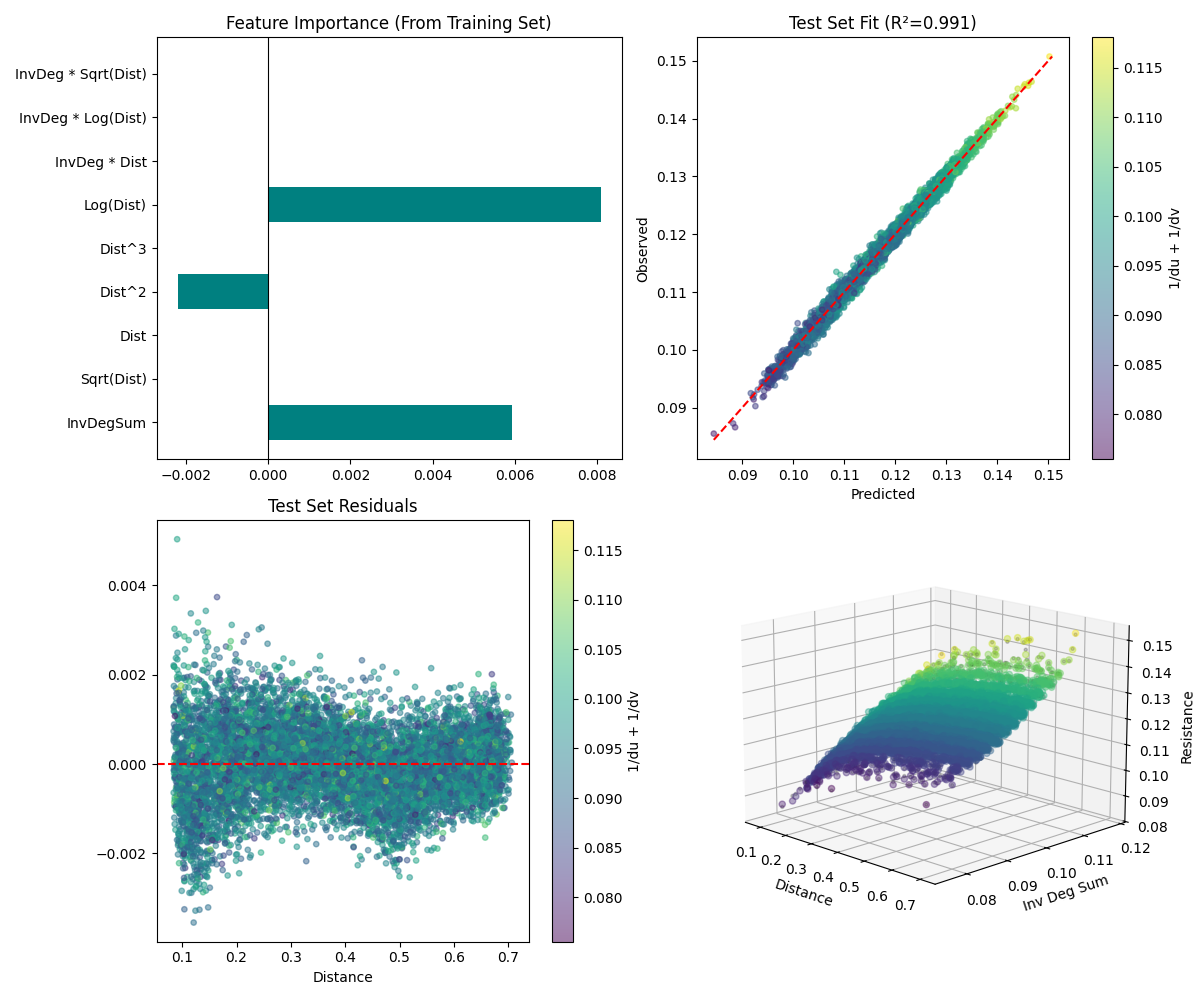

In [ ]:
%matplotlib widget
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import sys, os, webbrowser
import warnings

# --- ML IMPORTS ---
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# --- LIBRARY IMPORTS ---
sys.path.insert(0, "/Users/for/Desktop") 
from RGG_Library import RGGBuilder, RGGVisualizer

# --- CONFIGURATION ---
space_ = "triangular_torus"  # Switch to "triangular_torus" if needed
features_ = [0, "invdegfixed"][0] # 0 = Normal features, 1 = Triangle features

TOTAL_SEEDS = 100
TEST_SPLIT_INDEX = 70  # Seeds 0 to 69 are TRAIN, 70 to 99 are TEST

def get_feature_matrix(degs, dists):
    """
    Centralized feature engineering to ensure Training and Test sets 
    have identical columns.
    """
    # Avoid log(0)
    safe_dists = dists.copy()
    safe_dists[safe_dists == 0] = 1e-9

    feature_dict_normal = {
        "InvDegSum": degs,                                  
        "Sqrt(Dist)": np.sqrt(dists),                       
        "Dist": dists,                                      
        "Dist^2": dists**2,                                 
        "Dist^3": dists**3,                                 
        "Log(Dist)": np.log(safe_dists),                    
        "InvDeg * Dist": degs * dists,                      
        "InvDeg * Log(Dist)": degs * np.log(safe_dists),    
        "InvDeg * Sqrt(Dist)": degs * np.sqrt(dists)     
    }
    
    feature_dict_triangle = {
        "Sqrt(Dist)": np.sqrt(dists),                       
        "Dist": dists,                                      
        "Dist^2": dists**2,                                 
        "Dist^3": dists**3,                                 
        "Log(Dist)": np.log(safe_dists),                    
    }

    if features_ == "invdegfixed":
        feature_dict = feature_dict_triangle
    else:
        feature_dict = feature_dict_normal

    feature_names = list(feature_dict.keys())
    X = np.column_stack(list(feature_dict.values()))
    return X, feature_names

def generate_data(seed, n, k, nsamples):
    """
    Generates one graph and samples data for a single seed.
    """
    # sc for fixed mean degree
    builder = RGGBuilder(n=n, k=k, connectivity_regime="sc", space=space_, order=4, 
                         perturb=True, perturb_scale=0.01, perturb_radius_multiplier=1, seed=seed) 
    
    G = builder.build()

    # Ensure Giant Component
    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        if components:
            Gsub = G.subgraph(max(components, key=len)).copy()
        else:
            return None, None, None, None, None # Empty graph
    else:
        Gsub = G

    Gsub = nx.convert_node_labels_to_integers(Gsub, ordering="sorted")
    
    # Sampling
    random.seed(seed)
    np.random.seed(seed)
    
    res, degs, dists, pairs = RGGBuilder.sample_commute_times_even_distance(
        Gsub, nsamples=nsamples, n_bins=10, seed=seed, min_dist=builder.radius
    )
    
    if len(res) < 10:
        return None, None, None, None, Gsub

    return res, degs, dists, pairs, Gsub

def run_ml_trials(n=1000, k=20, nsamples=100):
    print(f"Starting ML Trials on {TOTAL_SEEDS} seeds...")
    print(f"Train Set: Seeds 0-{TEST_SPLIT_INDEX-1}")
    print(f"Test Set : Seeds {TEST_SPLIT_INDEX}-{TOTAL_SEEDS-1}")

    # Containers for Training Data
    X_train_list, y_train_list = [], []
    
    # Containers for Test Data (we keep raw vectors for plotting later)
    X_test_list, y_test_list = [], []
    degs_test_list, dists_test_list = [], []

    last_Gsub = None # Keep the last graph for HTML viz
    feature_names = []

    # --- DATA COLLECTION LOOP ---
    for seed in range(TOTAL_SEEDS):
        # Progress indicator
        if seed % 10 == 0: print(f"Processing seed {seed}...", end="\r")

        y_raw, degs, dists, _, Gsub = generate_data(seed, n, k, nsamples)
        
        if y_raw is None: continue # Skip failed generations
        last_Gsub = Gsub

        # Feature Engineering
        X_raw, f_names = get_feature_matrix(degs, dists)
        feature_names = f_names # Update names (they are static)

        # Split logic
        if seed < TEST_SPLIT_INDEX:
            # Add to TRAIN (First 70)
            X_train_list.append(X_raw)
            y_train_list.append(y_raw)
        else:
            # Add to TEST (Last 30)
            X_test_list.append(X_raw)
            y_test_list.append(y_raw)
            degs_test_list.append(degs)
            dists_test_list.append(dists)

    print(f"\nData collection complete.")
    
    # Consolidate Data
    if not X_train_list or not X_test_list:
        print("Error: Not enough data collected.")
        return

    X_train = np.vstack(X_train_list)
    y_train = np.concatenate(y_train_list)
    
    X_test = np.vstack(X_test_list)
    y_test = np.concatenate(y_test_list)
    
    # For plotting, we need concatenated raw metrics for the test set
    degs_test = np.concatenate(degs_test_list)
    dists_test = np.concatenate(dists_test_list)

    print(f"Training Samples: {len(y_train)} | Test Samples: {len(y_test)}")

    # ---------------------------
    # LASSO REGRESSION
    # ---------------------------
    print("\n--- Training LassoCV on Combined Training Seeds ---")
    
    model = make_pipeline(
        StandardScaler(), 
        LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=10000)
    )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)

    # Evaluate
    lasso = model.named_steps['lassocv']
    intercept = lasso.intercept_
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    print(f"\nBest Alpha: {lasso.alpha_:.6f}")
    print(f"Train R²:   {train_score:.4f}")
    print(f"Test R²:    {test_score:.4f}  <-- Performance on unseen seeds")

    print(f"Intercept : {intercept:.4f}")
    
    print("\nSelected Features:")
    coefs = lasso.coef_
    sorted_idx = np.argsort(np.abs(coefs))[::-1]
    for i in sorted_idx:
        if abs(coefs[i]) > 1e-4:
            print(f"{feature_names[i]:<20} : {coefs[i]:.6f}")

    # ---------------------------
    # VISUALIZATION (TEST SET)
    # ---------------------------
    # Subsample Test Set for plotting (Plotting 100k+ points is slow)
    plot_n = 10000
    if len(y_test) > plot_n:
        idx = np.random.choice(len(y_test), plot_n, replace=False)
        y_plot = y_test[idx]
        X_plot = X_test[idx]
        degs_plot = degs_test[idx]
        dists_plot = dists_test[idx]
    else:
        y_plot = y_test
        X_plot = X_test
        degs_plot = degs_test
        dists_plot = dists_test

    y_pred_plot = model.predict(X_plot)
    residuals = y_plot - y_pred_plot

    fig = plt.figure(figsize=(12, 10))
    cmap = "viridis"

    # 1. Feature Importance
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.barh(feature_names, coefs, color='teal')
    ax1.axvline(0, color='k', linewidth=0.8)
    ax1.set_title("Feature Importance (From Training Set)")

    # 2. Fit (Test Set)
    ax2 = fig.add_subplot(2, 2, 2)
    sc1 = ax2.scatter(y_pred_plot, y_plot, c=degs_plot, cmap=cmap, alpha=0.5, s=15)
    lims = [min(y_plot.min(), y_pred_plot.min()), max(y_plot.max(), y_pred_plot.max())]
    ax2.plot(lims, lims, 'r--', lw=1.5)
    ax2.set_title(f"Test Set Fit (R²={test_score:.3f})")
    ax2.set_xlabel("Predicted")
    ax2.set_ylabel("Observed")
    plt.colorbar(sc1, ax=ax2, label="1/du + 1/dv")

    # 3. Residuals (Test Set)
    ax3 = fig.add_subplot(2, 2, 3)
    sc2 = ax3.scatter(dists_plot, residuals, c=degs_plot, cmap=cmap, alpha=0.5, s=15)
    ax3.axhline(0, color='r', linestyle='--')
    ax3.set_title("Test Set Residuals")
    ax3.set_xlabel("Distance")
    plt.colorbar(sc2, ax=ax3, label="1/du + 1/dv")

    # 4. 3D Profile (Test Set)
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    sc3 = ax4.scatter(dists_plot, degs_plot, y_plot, c=degs_plot, cmap=cmap, alpha=0.4, s=20, label='Observed')
    ax4.scatter(dists_plot, degs_plot, y_pred_plot, c='k', alpha=0.2, s=5, label='Predicted')
    ax4.set_xlabel("Distance")
    ax4.set_ylabel("Inv Deg Sum")
    ax4.set_zlabel("Resistance")
    ax4.view_init(elev=15, azim=315)

    plt.tight_layout()
    plt.show()

    return last_Gsub

# ---------------------------
# RUN
# ---------------------------
# Running with higher n/k as per example, adjusted for 100 trials speed
# Reduce nsamples to 500 per graph since we have 100 graphs (Total 50k samples)
last_Gsub = run_ml_trials(n=1000, k=22, nsamples=500)

## Unit Square - Mean degree 22 - 1000 nodes

Starting ML Trials on 100 seeds...
Train Set: Seeds 0-69
Test Set : Seeds 70-99
Processing seed 90...
Data collection complete.
Training Samples: 35000 | Test Samples: 15000

--- Training LassoCV on Combined Training Seeds ---

Best Alpha: 0.000043
Train R²:   0.7678
Test R²:    0.7743  <-- Performance on unseen seeds
Intercept : 0.1738

Selected Features:
InvDegSum            : 0.038857
Log(Dist)            : 0.030074
InvDeg * Log(Dist)   : -0.012480
InvDeg * Dist        : -0.003213
Dist^3               : -0.001210


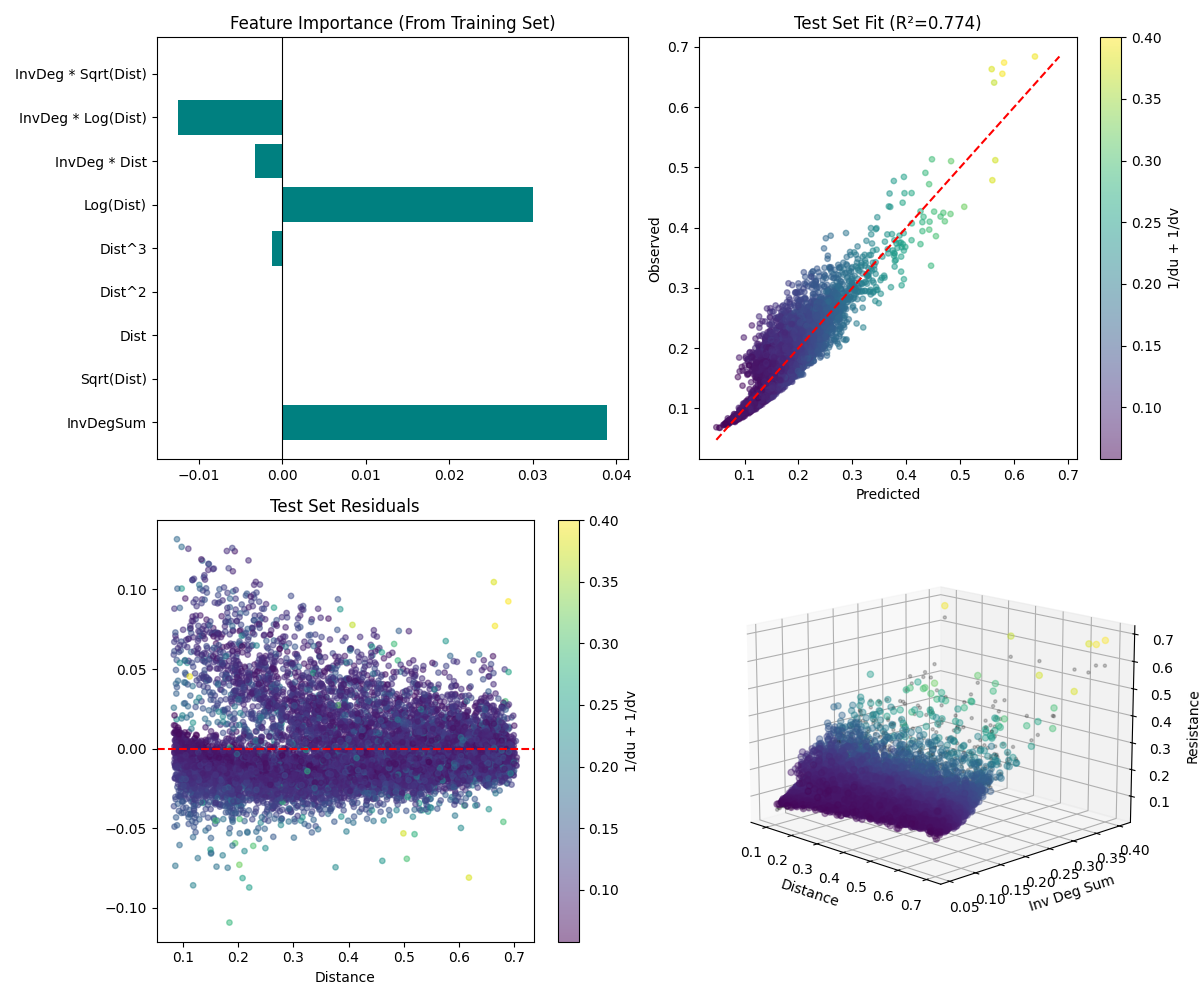

In [ ]:
%matplotlib widget
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import sys, os, webbrowser
import warnings

# --- ML IMPORTS ---
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# --- LIBRARY IMPORTS ---
sys.path.insert(0, "/Users/for/Desktop") 
from RGG_Library import RGGBuilder, RGGVisualizer

# --- CONFIGURATION ---
space_ = "unit_square"  # Switch to "triangular_torus" if needed
features_ = [0, "invdegfixed"][0] # 0 = Normal features, 1 = Triangle features

TOTAL_SEEDS = 100
TEST_SPLIT_INDEX = 70  # Seeds 0 to 69 are TRAIN, 70 to 99 are TEST

def get_feature_matrix(degs, dists):
    """
    Centralized feature engineering to ensure Training and Test sets 
    have identical columns.
    """
    # Avoid log(0)
    safe_dists = dists.copy()
    safe_dists[safe_dists == 0] = 1e-9

    feature_dict_normal = {
        "InvDegSum": degs,                                  
        "Sqrt(Dist)": np.sqrt(dists),                       
        "Dist": dists,                                      
        "Dist^2": dists**2,                                 
        "Dist^3": dists**3,                                 
        "Log(Dist)": np.log(safe_dists),                    
        "InvDeg * Dist": degs * dists,                      
        "InvDeg * Log(Dist)": degs * np.log(safe_dists),    
        "InvDeg * Sqrt(Dist)": degs * np.sqrt(dists)     
    }
    
    feature_dict_triangle = {
        "Sqrt(Dist)": np.sqrt(dists),                       
        "Dist": dists,                                      
        "Dist^2": dists**2,                                 
        "Dist^3": dists**3,                                 
        "Log(Dist)": np.log(safe_dists),                    
    }

    if features_ == "invdegfixed":
        feature_dict = feature_dict_triangle
    else:
        feature_dict = feature_dict_normal

    feature_names = list(feature_dict.keys())
    X = np.column_stack(list(feature_dict.values()))
    return X, feature_names

def generate_data(seed, n, k, nsamples):
    """
    Generates one graph and samples data for a single seed.
    """
    # sc for fixed mean degree
    builder = RGGBuilder(n=n, k=k, connectivity_regime="sc", space=space_, order=4, 
                         perturb=True, perturb_scale=0.01, perturb_radius_multiplier=1, seed=seed) 
    
    G = builder.build()

    # Ensure Giant Component
    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        if components:
            Gsub = G.subgraph(max(components, key=len)).copy()
        else:
            return None, None, None, None, None # Empty graph
    else:
        Gsub = G

    Gsub = nx.convert_node_labels_to_integers(Gsub, ordering="sorted")
    
    # Sampling
    random.seed(seed)
    np.random.seed(seed)
    
    res, degs, dists, pairs = RGGBuilder.sample_commute_times_even_distance(
        Gsub, nsamples=nsamples, n_bins=10, seed=seed, min_dist=builder.radius
    )
    
    if len(res) < 10:
        return None, None, None, None, Gsub

    return res, degs, dists, pairs, Gsub

def run_ml_trials(n=1000, k=22, nsamples=100):
    print(f"Starting ML Trials on {TOTAL_SEEDS} seeds...")
    print(f"Train Set: Seeds 0-{TEST_SPLIT_INDEX-1}")
    print(f"Test Set : Seeds {TEST_SPLIT_INDEX}-{TOTAL_SEEDS-1}")

    # Containers for Training Data
    X_train_list, y_train_list = [], []
    
    # Containers for Test Data (we keep raw vectors for plotting later)
    X_test_list, y_test_list = [], []
    degs_test_list, dists_test_list = [], []

    last_Gsub = None # Keep the last graph for HTML viz
    feature_names = []

    # --- DATA COLLECTION LOOP ---
    for seed in range(TOTAL_SEEDS):
        # Progress indicator
        if seed % 10 == 0: print(f"Processing seed {seed}...", end="\r")

        y_raw, degs, dists, _, Gsub = generate_data(seed, n, k, nsamples)
        
        if y_raw is None: continue # Skip failed generations
        last_Gsub = Gsub

        # Feature Engineering
        X_raw, f_names = get_feature_matrix(degs, dists)
        feature_names = f_names # Update names (they are static)

        # Split logic
        if seed < TEST_SPLIT_INDEX:
            # Add to TRAIN (First 70)
            X_train_list.append(X_raw)
            y_train_list.append(y_raw)
        else:
            # Add to TEST (Last 30)
            X_test_list.append(X_raw)
            y_test_list.append(y_raw)
            degs_test_list.append(degs)
            dists_test_list.append(dists)

    print(f"\nData collection complete.")
    
    # Consolidate Data
    if not X_train_list or not X_test_list:
        print("Error: Not enough data collected.")
        return

    X_train = np.vstack(X_train_list)
    y_train = np.concatenate(y_train_list)
    
    X_test = np.vstack(X_test_list)
    y_test = np.concatenate(y_test_list)
    
    # For plotting, we need concatenated raw metrics for the test set
    degs_test = np.concatenate(degs_test_list)
    dists_test = np.concatenate(dists_test_list)

    print(f"Training Samples: {len(y_train)} | Test Samples: {len(y_test)}")

    # ---------------------------
    # LASSO REGRESSION
    # ---------------------------
    print("\n--- Training LassoCV on Combined Training Seeds ---")
    
    model = make_pipeline(
        StandardScaler(), 
        LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=10000)
    )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)

    # Evaluate
    lasso = model.named_steps['lassocv']
    intercept = lasso.intercept_
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    print(f"\nBest Alpha: {lasso.alpha_:.6f}")
    print(f"Train R²:   {train_score:.4f}")
    print(f"Test R²:    {test_score:.4f}  <-- Performance on unseen seeds")

    print(f"Intercept : {intercept:.4f}")
    
    print("\nSelected Features:")
    coefs = lasso.coef_
    sorted_idx = np.argsort(np.abs(coefs))[::-1]
    for i in sorted_idx:
        if abs(coefs[i]) > 1e-4:
            print(f"{feature_names[i]:<20} : {coefs[i]:.6f}")

    # ---------------------------
    # VISUALIZATION (TEST SET)
    # ---------------------------
    # Subsample Test Set for plotting (Plotting 100k+ points is slow)
    plot_n = 10000
    if len(y_test) > plot_n:
        idx = np.random.choice(len(y_test), plot_n, replace=False)
        y_plot = y_test[idx]
        X_plot = X_test[idx]
        degs_plot = degs_test[idx]
        dists_plot = dists_test[idx]
    else:
        y_plot = y_test
        X_plot = X_test
        degs_plot = degs_test
        dists_plot = dists_test

    y_pred_plot = model.predict(X_plot)
    residuals = y_plot - y_pred_plot

    fig = plt.figure(figsize=(12, 10))
    cmap = "viridis"

    # 1. Feature Importance
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.barh(feature_names, coefs, color='teal')
    ax1.axvline(0, color='k', linewidth=0.8)
    ax1.set_title("Feature Importance (From Training Set)")

    # 2. Fit (Test Set)
    ax2 = fig.add_subplot(2, 2, 2)
    sc1 = ax2.scatter(y_pred_plot, y_plot, c=degs_plot, cmap=cmap, alpha=0.5, s=15)
    lims = [min(y_plot.min(), y_pred_plot.min()), max(y_plot.max(), y_pred_plot.max())]
    ax2.plot(lims, lims, 'r--', lw=1.5)
    ax2.set_title(f"Test Set Fit (R²={test_score:.3f})")
    ax2.set_xlabel("Predicted")
    ax2.set_ylabel("Observed")
    plt.colorbar(sc1, ax=ax2, label="1/du + 1/dv")

    # 3. Residuals (Test Set)
    ax3 = fig.add_subplot(2, 2, 3)
    sc2 = ax3.scatter(dists_plot, residuals, c=degs_plot, cmap=cmap, alpha=0.5, s=15)
    ax3.axhline(0, color='r', linestyle='--')
    ax3.set_title("Test Set Residuals")
    ax3.set_xlabel("Distance")
    plt.colorbar(sc2, ax=ax3, label="1/du + 1/dv")

    # 4. 3D Profile (Test Set)
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    sc3 = ax4.scatter(dists_plot, degs_plot, y_plot, c=degs_plot, cmap=cmap, alpha=0.4, s=20, label='Observed')
    ax4.scatter(dists_plot, degs_plot, y_pred_plot, c='k', alpha=0.2, s=5, label='Predicted')
    ax4.set_xlabel("Distance")
    ax4.set_ylabel("Inv Deg Sum")
    ax4.set_zlabel("Resistance")
    ax4.view_init(elev=15, azim=315)

    plt.tight_layout()
    plt.show()

    return last_Gsub

# ---------------------------
# RUN
# ---------------------------
# Running with higher n/k as per example, adjusted for 100 trials speed
# Reduce nsamples to 500 per graph since we have 100 graphs (Total 50k samples)
last_Gsub = run_ml_trials(n=1000, k=22, nsamples=500)